In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # limit gpu memory
    
from psychrnn.tasks.task import Task
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.models.lstm import LSTM
import numpy as np
import scipy.io
import pandas as pd
import pickle
import numpy as np
from itertools import product
from typing import *
import os
import json
from uuid import uuid4, UUID
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot

2022-11-20 23:10:52.318087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 23:10:52.413184: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 23:10:52.743242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2022-11-20 23:10:52.743282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

In [2]:
tf.random.set_seed(0)

# Load data

In [3]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [4]:
m['realigned_traj_v2'].shape

(653, 3, 151)

In [5]:
directions = m["direction_YQ1"].flatten()
np.unique(directions)

array([1, 2], dtype=uint8)

In [6]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [7]:
traj_origin.shape

(156, 3, 151)

RFBOutputContext()

/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/fastplotlib/subplot.py:120: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



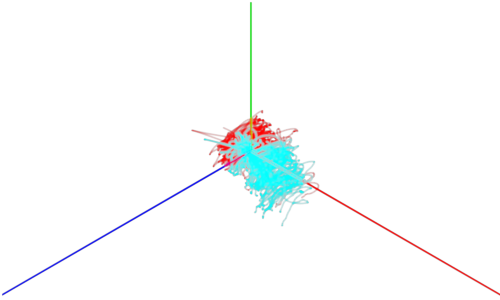

JupyterWgpuCanvas()

In [8]:
m['realigned_traj_v2']

plot = Plot(camera="3d")

for t in traj_origin[directions == 1]:
    c = np.array([[1, 0, 0, 0.5]] * t.shape[1])
    plot.line(t.T, size=2, colors=c)
    
for t in traj_origin[directions == 2]:
    c = np.array([[0, 1, 1, 0.5]] * t.shape[1])
    plot.line(t.T, size=2, colors=c)

plot.set_axes_visibility(True)
plot.show()

# Define behavioral task, basically just samples `traj_data`

In [9]:
class Reach2Grab(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(Reach2Grab, self).__init__(1, 2, dt, tau, T, N_batch)

    def generate_trial_params(self, batch, trial):
        params = dict()
        trial_ix = np.random.randint(traj_origin.shape[2])
        params["trial_ix"] = trial_ix
        
        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.
            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """
        trial_ix = params["trial_ix"]
        direction = (directions == directions[trial_ix])
        
        x_t = np.concatenate(
            [
                np.array(
                    [np.random.normal(
                        loc=traj_origin[direction, d, -1].mean(), 
                        scale=traj_origin[direction, d, -1].std(), 
                        size=1
                    ).item() for d in range(3)]), 
                np.array([directions[trial_ix] -1])
            ]
        )
        
        y_t = traj_origin[trial_ix, :, time]
        
        mask_t = np.ones(shape=y_t.shape, dtype=bool)
        

        return x_t, y_t, mask_t

In [10]:
model_iter.destruct()

NameError: name 'model_iter' is not defined

In [11]:
task = Reach2Grab(dt=1, tau=50, T=151, N_batch=128)
    
network_params = task.get_task_params()
network_params['name'] = "bah"
network_params['N_rec'] = 5_000
network_params["N_in"] = 4
network_params["N_out"] = 3
# network_params['dale_ratio'] = 0.8

model_iter = Basic(network_params)

train_params = {
    "training_iters": 20_000,
    "learning_rate": 0.001,
}

model_iter.train(task, train_params)

2022-11-20 23:11:40.866761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 23:11:40.868314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:11:40.868862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:11:40.869359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Iter 1280, Minibatch Loss= 20.554918
Iter 2560, Minibatch Loss= 22.844975
Iter 3840, Minibatch Loss= 19.239933
Iter 5120, Minibatch Loss= 19.311838
Iter 6400, Minibatch Loss= 19.434439
Iter 7680, Minibatch Loss= 15.323651
Iter 8960, Minibatch Loss= 18.525463
Iter 10240, Minibatch Loss= 18.786562
Iter 11520, Minibatch Loss= 17.379929
Iter 12800, Minibatch Loss= 20.679972
Iter 14080, Minibatch Loss= 22.025530
Iter 15360, Minibatch Loss= 20.365454
Iter 16640, Minibatch Loss= 20.746326
Iter 17920, Minibatch Loss= 19.613493
Iter 19200, Minibatch Loss= 19.834097
Optimization finished!


([20.554918,
  22.844975,
  19.239933,
  19.311838,
  19.434439,
  15.323651,
  18.525463,
  18.786562,
  17.379929,
  20.679972,
  22.02553,
  20.365454,
  20.746326,
  19.613493,
  19.834097],
 247.6349937915802,
 6.016692876815796)

In [12]:
inputs = task.get_trial_batch()[0]
output_dirs = inputs[:, :, -1].ravel()[::151]

In [13]:
with tf.device('/cpu:0'):
    output, state = model_iter.test(inputs)

In [14]:
output = output.swapaxes(1, 2)

output_origin =  (output.T - output[:, :, 0].T).T

In [15]:
output.shape

(128, 3, 151)

In [16]:
from fastplotlib import Plot

RFBOutputContext()


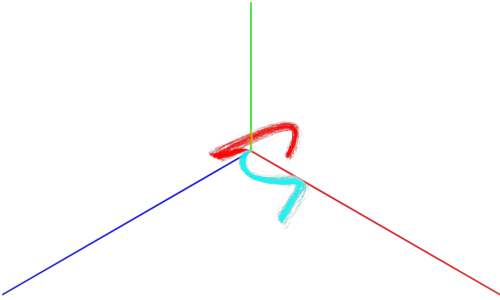

JupyterWgpuCanvas()

In [17]:
plot = Plot(camera="3d")

cmap = {
    0: np.array([[1, 0, 0, 0.5]] * 151),
    1: np.array([[0, 1, 1, 0.5]] * 151),
}

for i in range(output_origin.shape[0]):
    plot.line(output_origin[i, :, :].T * 2, size=1, alpha=0.5, colors=cmap[output_dirs[i]])

plot.set_axes_visibility(True)
plot.show()

In [117]:
weights["W_in"].shape

(5000, 4)

In [118]:
weights["W_rec"].shape

(5000, 5000)

In [122]:
weights["W_out"].shape

(3, 5000)

In [120]:
weights

{'init_state': array([[0.09115646, 0.08131597, 0.07589306, ..., 0.09376273, 0.08894617,
         0.07566372]], dtype=float32),
 'W_in': array([[ 0.01853853, -0.0063331 , -0.00487099, -0.00566799],
        [ 0.01012062, -0.00393812, -0.01271512,  0.00798598],
        [-0.00119389,  0.01009502, -0.01394733, -0.02203422],
        ...,
        [-0.01062787, -0.00399689, -0.0362209 , -0.01952109],
        [-0.02298682, -0.01896769,  0.00253459, -0.00729326],
        [-0.04501954, -0.00407649,  0.01849681, -0.01221621]],
       dtype=float32),
 'W_rec': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'W_out': array([[-0.01631158, -0.00513786, -0.01546012, ..., -0.01225806,
          0.02123155, -0.01595255],
        [ 0.00800422,  0.0188743 , -0.00545302, ...,  0.01438399,
      

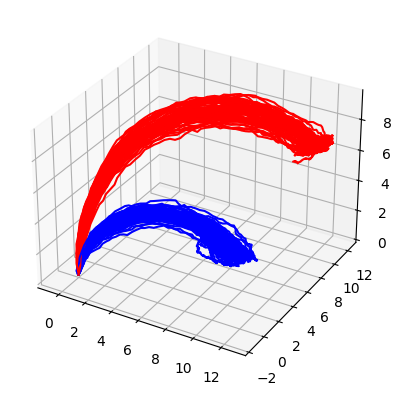

In [18]:
ax = plt.figure().add_subplot(projection="3d")

cmap = {
    0: "r",
    1: "b",
}

for i in range(output_origin.shape[0]):
    ax.plot(output_origin[i, 0, :], output_origin[i, 1, :], output_origin[i, 2, :], c=cmap[output_dirs[i]])
plt.show()

In [19]:
import seaborn as sns

In [71]:
weights = model_iter.get_weights()

<AxesSubplot:>

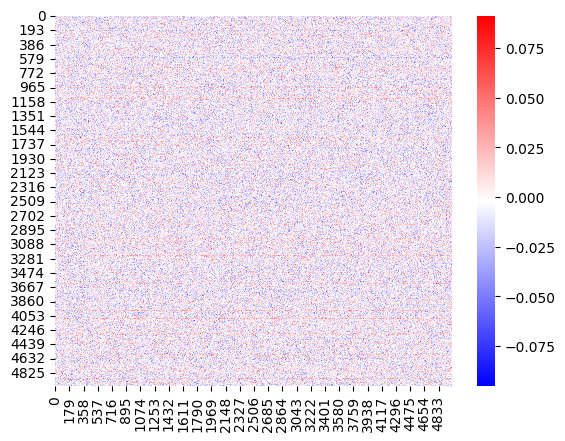

In [26]:
sns.heatmap(weights["W_rec"], cmap="bwr")

In [70]:
# weights['W_rec'][network_params['N_rec']//5*4:, :4*network_params['N_rec']//5] = 0
# weights['W_rec'][:4*network_params['N_rec']//5, network_params['N_rec']//5*4:] = 0

weights['W_rec'][2000:3000, 2000:3000] = 0
weights['W_rec'][2000:3000, 2000:3000] = 0

TypeError: 'int' object does not support item assignment

In [72]:
weights['W_rec'][:, :] = 0

<AxesSubplot:>

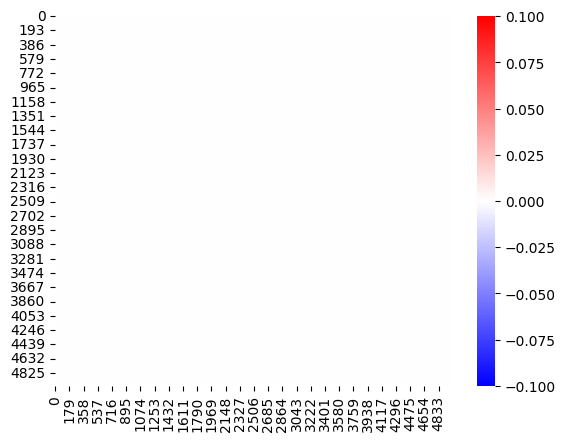

In [73]:
sns.heatmap(weights["W_rec"], cmap="bwr")

In [109]:
# psychrnn is so damn stupid
pruned_network_params = network_params.copy()
pruned_network_params["name"] = "pruned5"

for k, v in weights.items():
    pruned_network_params[k] = v
    
pruned_model = Basic(pruned_network_params)

In [110]:
inputs = task.get_trial_batch()[0]
output_dirs = inputs[:, :, -1].ravel()[::151]

In [111]:
with tf.device('/cpu:0'):
    o_pruned, state = pruned_model.test(inputs)

2022-11-20 23:50:17.001964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:50:17.002254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:50:17.002454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:50:17.002692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 23:50:17.002896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [112]:
o_pruned = o_pruned.swapaxes(1, 2)

# set 0 point at origin
o_pruned =  (output.T - output[:, :, 0].T).T

In [113]:
state.shape

(128, 151, 5000)

In [114]:
from fastplotlib import Plot

RFBOutputContext()

/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/fastplotlib/subplot.py:120: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



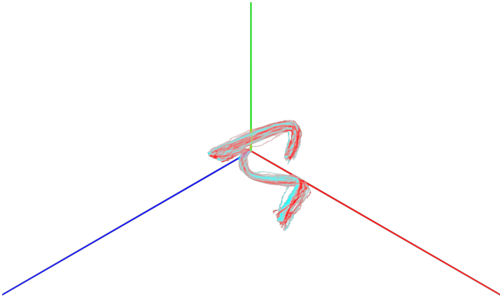

JupyterWgpuCanvas()

In [115]:
plot = Plot(camera="3d")

cmap = {
    0: np.array([[1, 0, 0, 0.5]] * 151),
    1: np.array([[0, 1, 1, 0.5]] * 151),
}

for i in range(output_origin.shape[0]):
    plot.line(o_pruned[i, :, :].T * 2, size=1.5, alpha=0.5, colors=cmap[output_dirs[i]])

plot.set_axes_visibility(True)
plot.show()